In [1]:
from jupyterthemes import jtplot
jtplot.style(theme='monokai',context="notebook",ticks=True, grid=False)
jtplot.style(context='talk', fscale=1.2, spines=False, gridlines='--')
jtplot.style(figsize=(6, 4.5))
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sts
%matplotlib inline

In [2]:
import tensorflow as tf 
import sklearn 
import seaborn as sns  
import matplotlib.pyplot as plt
import xgboost 
import pandas as pd 
import random 
random.seed = 1

In [3]:
data_dictionary_path =  "/home/vladislav/PycharmProjects/Kaggle/Titanic/data/"
data = data_dictionary_path + "train.csv"
test_path = data_dictionary_path + "test.csv"
submit_path = data_dictionary_path + "gender_submission.csv"

In [4]:
data = pd.read_csv(data)
test = pd.read_csv(test_path)
submit = pd.read_csv(submit_path)

In [5]:
y = data["Survived"] 
data = data.drop(["PassengerId","Survived","Name"],axis=1)
test = test.drop(["PassengerId","Name"],axis=1)

In [6]:
data.head(10)

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,3,male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,female,35.0,1,0,113803,53.1000,C123,S
4,3,male,35.0,0,0,373450,8.0500,NaN,S
5,3,male,NaN,0,0,330877,8.4583,NaN,Q
6,1,male,54.0,0,0,17463,51.8625,E46,S
7,3,male,2.0,3,1,349909,21.0750,NaN,S
8,3,female,27.0,0,2,347742,11.1333,NaN,S
9,2,female,14.0,1,0,237736,30.0708,NaN,C


In [7]:
data.isna().sum()

Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

Cabin has 687 Nan values. This column haven't anough information. 
Alse we have 2 raws with "Nan" Embarked values. The easy way to handle them - DELETE. We will loss only 2 training objects - it won't decrease our model perfomence. 

In [8]:
data = data.drop(["Cabin"],axis=1)
test = test.drop(["Cabin"],axis=1)

In [9]:
mask = data.Embarked.isnull() != True
data = data[mask]
y = y[mask]

Text(0.5, 1.0, 'Age distribution')

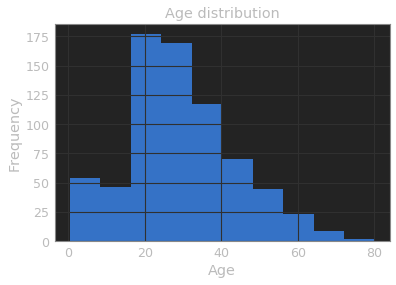

In [10]:
Age = data.Age.copy()
Age = Age[Age.isnull() != True] 
plt.hist(Age)
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.title("Age distribution")

age in our data can be represent as - left skewness normal distibution.<br>
The first thoung is to replace Age with Mean / Median values from distribution. <br>
Now we must fing corr between Age and [ Fare,Sex,Embarked,Pclass]. This will help us to replace Nan values via pattern. 

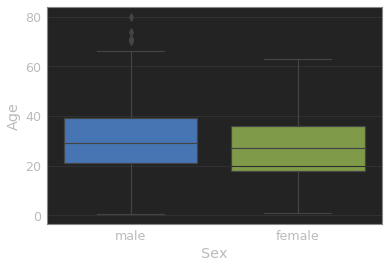

In [11]:
data_to_see_corr = data[data.Age.isnull() != True]
sns.boxplot(x= "Sex",y= "Age",data=data_to_see_corr)

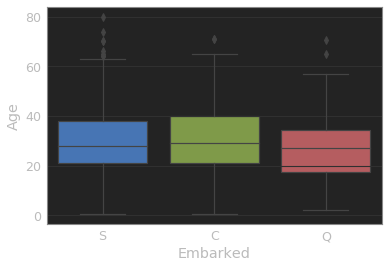

In [12]:
sns.boxplot(x= "Embarked",y= "Age",data=data_to_see_corr)

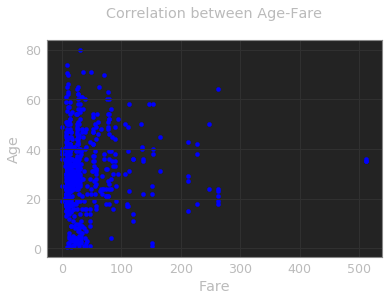

In [13]:
data.plot(x="Fare",y="Age",kind="scatter",color="blue",title = "Correlation between Age-Fare\n")

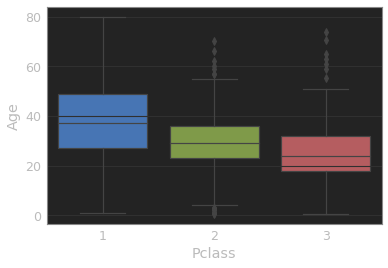

In [14]:
sns.boxplot(x= "Pclass",y= "Age",data=data_to_see_corr)

Four plots help us to understand, that these three features : Fare,Sex,Embarked don't correlate with Age.<br>
But Pclass give us assumption, that the younger person is - the bigger class he buys <br>
We can fillna our Age missed values with :
* Median
* Mean
* Fill the ages of all the people, with mean/median value of their Pclasses.

In [15]:
#data["Age"]=data["Age"].fillna(data["Age"].median())
#test["Age"]=test["Age"].fillna(data["Age"].median())

In [16]:
data["Ticket"].nunique()
print( f"Ticket has {round(data['Ticket'].nunique()/len(data.Ticket),2)*100}% unique values")

Ticket has 76.0% unique values


Ticket feature have 76% unique values. We can assume, that this feature is not important in our dataset.

In [17]:
data = data.drop(['Ticket'],axis=1)
test = test.drop(['Ticket'],axis=1) 

What about SibSp and Parch ?

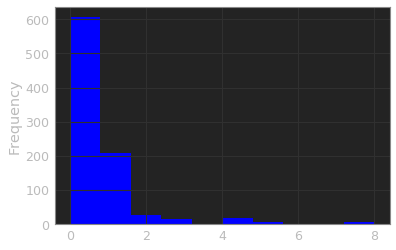

In [18]:
data.SibSp.plot(kind="hist",color="blue")

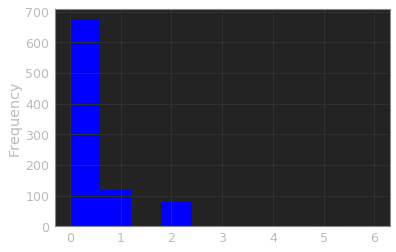

In [19]:
data.Parch.plot(kind="hist",color="blue")

After analyzing these histograms - i decide to binarize this two features 

In [20]:
data['Parch'] = data['Parch'].where(data['Parch'] ==0,1)
data['SibSp'] = data['SibSp'].where(data['SibSp'] ==0,1)

Text(0, 0.5, 'Frequency')

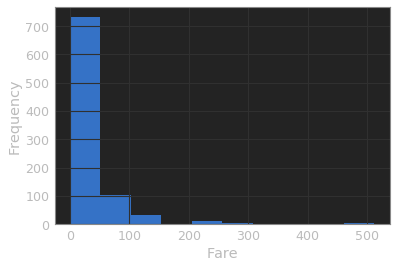

In [21]:
plt.hist(data["Fare"])
plt.xlabel("Fare")
plt.ylabel("Frequency")

Have we balanced Y classes or not ? Let's check 

(array([549.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 340.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

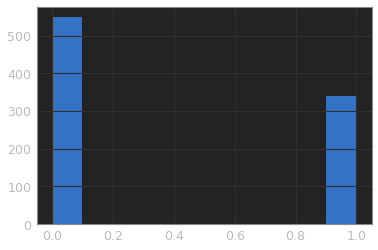

In [22]:
plt.hist(y)

In [23]:
print(f"First label class : {sum(y.where(y==1,0))}")
print(f"Second label class : {len(y)-sum(y.where(y==1,0))}")

First label class : 340
Second label class : 549


In [24]:
print(f"Also we have : {int(round(340/len(y),2)*100)}% and {int(round(549/len(y),2)*100)}% distributed classes")

Also we have : 38% and 62% distributed classes


We have a problem with disbalansed dataset. 

In [25]:
data.dtypes

Pclass        int64
Sex          object
Age         float64
SibSp         int64
Parch         int64
Fare        float64
Embarked     object
dtype: object

In [26]:
data.corr()

,Pclass,Age,SibSp,Parch,Fare
Pclass,1.000000,-0.365902,-0.078671,-0.029593,-0.548193
Age,-0.365902,1.000000,-0.160784,-0.279417,0.093143
SibSp,-0.078671,-0.160784,1.000000,0.419741,0.193970
Parch,-0.029593,-0.279417,0.419741,1.000000,0.239264
Fare,-0.548193,0.093143,0.193970,0.239264,1.000000


In [27]:
data.corrwith(y)

Pclass   -0.335549
Age      -0.082446
SibSp     0.118087
Parch     0.149328
Fare      0.255290
dtype: float64

In [28]:
from sklearn.model_selection import train_test_split
(X_train,X_test,y_train,y_test) = train_test_split(data,y,test_size=0.2, random_state=0,stratify=y)

In [29]:
Categorial_features = ["Pclass","Sex","Embarked","SibSp","Parch"]
Numerical_features = ["Age","Fare"]

In [30]:
from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_openml
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV

numeric_transormer=Pipeline(steps = [
    ("imputer",SimpleImputer(strategy="median")),
    ("scaler",StandardScaler())
])

cat_transormer = Pipeline(steps=[
    ("imputer",SimpleImputer(strategy='constant', fill_value='missing')),
    ("encoder",OneHotEncoder(handle_unknown="ignore"))    
])

preprocessor = ColumnTransformer(
transformers = [
    ("num",numeric_transormer,Numerical_features) ,
    ("cat",cat_transormer,Categorial_features)
])


In [31]:
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LogisticRegression(class_weight="None"))])
param_grid = {
    'preprocessor__num__imputer__strategy': ['mean', 'median'],
    'classifier__C': [0.01,0.1,0.5, 1.0, 5, 10],
    'classifier__class_weight': ["None","balanced"],
    'classifier__solver':['lbfgs', 'liblinear'],
    'classifier__penalty':['l1','l2'],
}
grid_search_1 = GridSearchCV(clf, param_grid, cv=5)
grid_search_1.fit(X_train, y_train)

/home/vladislav/anaconda3/envs/tftestenv/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/vladislav/anaconda3/envs/tftestenv/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/vladislav/anaconda3/envs/tftestenv/lib/python3.7/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/home/vladislav/anaconda3/envs/tftestenv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/vladislav/anaconda3/envs/tftestenv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    "got %s p

/home/vladislav/anaconda3/envs/tftestenv/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/vladislav/anaconda3/envs/tftestenv/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/vladislav/anaconda3/envs/tftestenv/lib/python3.7/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/home/vladislav/anaconda3/envs/tftestenv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1360, in fit
    sample_weight=sample_weight)
  File "/home/vladislav/anaconda3/envs/tftestenv/lib/python3.7/site-packages/sklearn/svm/_base.py", line 931, in _fit_liblinear
    y=y)
  File "/home/vladislav/anaconda3/envs/tftestenv

/home/vladislav/anaconda3/envs/tftestenv/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/vladislav/anaconda3/envs/tftestenv/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/vladislav/anaconda3/envs/tftestenv/lib/python3.7/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/home/vladislav/anaconda3/envs/tftestenv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/vladislav/anaconda3/envs/tftestenv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    "got %s p

/home/vladislav/anaconda3/envs/tftestenv/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/vladislav/anaconda3/envs/tftestenv/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/vladislav/anaconda3/envs/tftestenv/lib/python3.7/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/home/vladislav/anaconda3/envs/tftestenv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1360, in fit
    sample_weight=sample_weight)
  File "/home/vladislav/anaconda3/envs/tftestenv/lib/python3.7/site-packages/sklearn/svm/_base.py", line 931, in _fit_liblinear
    y=y)
  File "/home/vladislav/anaconda3/envs/tftestenv

/home/vladislav/anaconda3/envs/tftestenv/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/vladislav/anaconda3/envs/tftestenv/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/vladislav/anaconda3/envs/tftestenv/lib/python3.7/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/home/vladislav/anaconda3/envs/tftestenv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/vladislav/anaconda3/envs/tftestenv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    "got %s p

/home/vladislav/anaconda3/envs/tftestenv/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/vladislav/anaconda3/envs/tftestenv/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/vladislav/anaconda3/envs/tftestenv/lib/python3.7/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/home/vladislav/anaconda3/envs/tftestenv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1360, in fit
    sample_weight=sample_weight)
  File "/home/vladislav/anaconda3/envs/tftestenv/lib/python3.7/site-packages/sklearn/svm/_base.py", line 931, in _fit_liblinear
    y=y)
  File "/home/vladislav/anaconda3/envs/tftestenv

/home/vladislav/anaconda3/envs/tftestenv/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/vladislav/anaconda3/envs/tftestenv/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/vladislav/anaconda3/envs/tftestenv/lib/python3.7/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/home/vladislav/anaconda3/envs/tftestenv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/vladislav/anaconda3/envs/tftestenv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    "got %s p

/home/vladislav/anaconda3/envs/tftestenv/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/vladislav/anaconda3/envs/tftestenv/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/vladislav/anaconda3/envs/tftestenv/lib/python3.7/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/home/vladislav/anaconda3/envs/tftestenv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1360, in fit
    sample_weight=sample_weight)
  File "/home/vladislav/anaconda3/envs/tftestenv/lib/python3.7/site-packages/sklearn/svm/_base.py", line 931, in _fit_liblinear
    y=y)
  File "/home/vladislav/anaconda3/envs/tftestenv

/home/vladislav/anaconda3/envs/tftestenv/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/vladislav/anaconda3/envs/tftestenv/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/vladislav/anaconda3/envs/tftestenv/lib/python3.7/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/home/vladislav/anaconda3/envs/tftestenv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/vladislav/anaconda3/envs/tftestenv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    "got %s p

/home/vladislav/anaconda3/envs/tftestenv/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/vladislav/anaconda3/envs/tftestenv/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/vladislav/anaconda3/envs/tftestenv/lib/python3.7/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/home/vladislav/anaconda3/envs/tftestenv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1360, in fit
    sample_weight=sample_weight)
  File "/home/vladislav/anaconda3/envs/tftestenv/lib/python3.7/site-packages/sklearn/svm/_base.py", line 931, in _fit_liblinear
    y=y)
  File "/home/vladislav/anaconda3/envs/tftestenv

/home/vladislav/anaconda3/envs/tftestenv/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/vladislav/anaconda3/envs/tftestenv/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/vladislav/anaconda3/envs/tftestenv/lib/python3.7/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/home/vladislav/anaconda3/envs/tftestenv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/vladislav/anaconda3/envs/tftestenv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    "got %s p

/home/vladislav/anaconda3/envs/tftestenv/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/vladislav/anaconda3/envs/tftestenv/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/vladislav/anaconda3/envs/tftestenv/lib/python3.7/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/home/vladislav/anaconda3/envs/tftestenv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1360, in fit
    sample_weight=sample_weight)
  File "/home/vladislav/anaconda3/envs/tftestenv/lib/python3.7/site-packages/sklearn/svm/_base.py", line 931, in _fit_liblinear
    y=y)
  File "/home/vladislav/anaconda3/envs/tftestenv

/home/vladislav/anaconda3/envs/tftestenv/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/vladislav/anaconda3/envs/tftestenv/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/vladislav/anaconda3/envs/tftestenv/lib/python3.7/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/home/vladislav/anaconda3/envs/tftestenv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/vladislav/anaconda3/envs/tftestenv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    "got %s p

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['Age',
                                                                          'Fare']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
                                                              

In [32]:
print("Training Prefomence : " + str(grid_search_1.score(X_train, y_train)))

Training Prefomence : 0.7890295358649789


In [33]:
print("Test Perfomence : " + str(grid_search_1.score(X_test, y_test)))

Test Perfomence : 0.8426966292134831


Results with : GridSearch_1 / (medium/mean Age Imputer) / LogReg clf / Unbalalanced dataset<br>
* Training : 0.789 <br>
* Test : 0.842
Avoidable Bias problem

* Choose different algorithms <br>
* Try to use another technicks for balancing training data <br>
* Play with feature engineering <br>

Now we will balance our classes vie adding dublicate elements of smaller classes to itself

In [34]:
count_1=sum(y.where(y==1,0))
count_0=len(y)-count_1
diff_betw_cl = abs(count_1-count_0)
print(f"Objects of first class : {count_1} , {count_0}\ndiff = {diff_betw_cl}")

Objects of first class : 340 , 549
diff = 209


In [35]:
idx_whr_y_1 = y.index[y==1].tolist() 
idxs = np.array(random.choices(idx_whr_y_1,k=diff_betw_cl)) # sample idxs from idx_whr_y_1
idxs-=1 # to avoid index error 

In [36]:
data_balanced = pd.concat([ data , data.iloc[idxs] ])
y_balanced = pd.concat([ y , y.iloc[idxs] ])

(array([571.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 527.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

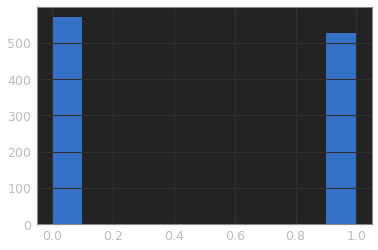

In [37]:
plt.hist(y_balanced)

We have balance dataset. Does it help us ?

In [38]:
from sklearn.model_selection import train_test_split
(X_train_balanced,X_test_balanced,y_train_balanced,y_test_balanced) = train_test_split(data_balanced,y_balanced,test_size=0.2, random_state=0,stratify=y_balanced)
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LogisticRegression(class_weight="None"))])
param_grid = {
    'preprocessor__num__imputer__strategy': ['mean', 'median'],
    'classifier__C': [0.01,0.1,0.5, 1.0, 5, 10],
    'classifier__class_weight': ["None","balanced"],
    'classifier__solver':['lbfgs', 'liblinear'],
    'classifier__penalty':['l1','l2'],
}
grid_search_2 = GridSearchCV(clf, param_grid, cv=5)
grid_search_2.fit(X_train_balanced, y_train_balanced)

/home/vladislav/anaconda3/envs/tftestenv/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/vladislav/anaconda3/envs/tftestenv/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/vladislav/anaconda3/envs/tftestenv/lib/python3.7/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/home/vladislav/anaconda3/envs/tftestenv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/vladislav/anaconda3/envs/tftestenv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    "got %s p

/home/vladislav/anaconda3/envs/tftestenv/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/vladislav/anaconda3/envs/tftestenv/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/vladislav/anaconda3/envs/tftestenv/lib/python3.7/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/home/vladislav/anaconda3/envs/tftestenv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1360, in fit
    sample_weight=sample_weight)
  File "/home/vladislav/anaconda3/envs/tftestenv/lib/python3.7/site-packages/sklearn/svm/_base.py", line 931, in _fit_liblinear
    y=y)
  File "/home/vladislav/anaconda3/envs/tftestenv

/home/vladislav/anaconda3/envs/tftestenv/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/vladislav/anaconda3/envs/tftestenv/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/vladislav/anaconda3/envs/tftestenv/lib/python3.7/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/home/vladislav/anaconda3/envs/tftestenv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/vladislav/anaconda3/envs/tftestenv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    "got %s p

/home/vladislav/anaconda3/envs/tftestenv/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/vladislav/anaconda3/envs/tftestenv/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/vladislav/anaconda3/envs/tftestenv/lib/python3.7/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/home/vladislav/anaconda3/envs/tftestenv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1360, in fit
    sample_weight=sample_weight)
  File "/home/vladislav/anaconda3/envs/tftestenv/lib/python3.7/site-packages/sklearn/svm/_base.py", line 931, in _fit_liblinear
    y=y)
  File "/home/vladislav/anaconda3/envs/tftestenv

/home/vladislav/anaconda3/envs/tftestenv/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/vladislav/anaconda3/envs/tftestenv/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/vladislav/anaconda3/envs/tftestenv/lib/python3.7/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/home/vladislav/anaconda3/envs/tftestenv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/vladislav/anaconda3/envs/tftestenv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    "got %s p

/home/vladislav/anaconda3/envs/tftestenv/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/vladislav/anaconda3/envs/tftestenv/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/vladislav/anaconda3/envs/tftestenv/lib/python3.7/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/home/vladislav/anaconda3/envs/tftestenv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1360, in fit
    sample_weight=sample_weight)
  File "/home/vladislav/anaconda3/envs/tftestenv/lib/python3.7/site-packages/sklearn/svm/_base.py", line 931, in _fit_liblinear
    y=y)
  File "/home/vladislav/anaconda3/envs/tftestenv

/home/vladislav/anaconda3/envs/tftestenv/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/vladislav/anaconda3/envs/tftestenv/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/vladislav/anaconda3/envs/tftestenv/lib/python3.7/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/home/vladislav/anaconda3/envs/tftestenv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/vladislav/anaconda3/envs/tftestenv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    "got %s p

/home/vladislav/anaconda3/envs/tftestenv/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/vladislav/anaconda3/envs/tftestenv/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/vladislav/anaconda3/envs/tftestenv/lib/python3.7/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/home/vladislav/anaconda3/envs/tftestenv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1360, in fit
    sample_weight=sample_weight)
  File "/home/vladislav/anaconda3/envs/tftestenv/lib/python3.7/site-packages/sklearn/svm/_base.py", line 931, in _fit_liblinear
    y=y)
  File "/home/vladislav/anaconda3/envs/tftestenv

/home/vladislav/anaconda3/envs/tftestenv/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/vladislav/anaconda3/envs/tftestenv/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/vladislav/anaconda3/envs/tftestenv/lib/python3.7/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/home/vladislav/anaconda3/envs/tftestenv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/vladislav/anaconda3/envs/tftestenv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    "got %s p

/home/vladislav/anaconda3/envs/tftestenv/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/vladislav/anaconda3/envs/tftestenv/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/vladislav/anaconda3/envs/tftestenv/lib/python3.7/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/home/vladislav/anaconda3/envs/tftestenv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1360, in fit
    sample_weight=sample_weight)
  File "/home/vladislav/anaconda3/envs/tftestenv/lib/python3.7/site-packages/sklearn/svm/_base.py", line 931, in _fit_liblinear
    y=y)
  File "/home/vladislav/anaconda3/envs/tftestenv

/home/vladislav/anaconda3/envs/tftestenv/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/vladislav/anaconda3/envs/tftestenv/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/vladislav/anaconda3/envs/tftestenv/lib/python3.7/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/home/vladislav/anaconda3/envs/tftestenv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/vladislav/anaconda3/envs/tftestenv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    "got %s p

/home/vladislav/anaconda3/envs/tftestenv/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/vladislav/anaconda3/envs/tftestenv/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/vladislav/anaconda3/envs/tftestenv/lib/python3.7/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/home/vladislav/anaconda3/envs/tftestenv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1360, in fit
    sample_weight=sample_weight)
  File "/home/vladislav/anaconda3/envs/tftestenv/lib/python3.7/site-packages/sklearn/svm/_base.py", line 931, in _fit_liblinear
    y=y)
  File "/home/vladislav/anaconda3/envs/tftestenv

/home/vladislav/anaconda3/envs/tftestenv/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/vladislav/anaconda3/envs/tftestenv/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/vladislav/anaconda3/envs/tftestenv/lib/python3.7/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/home/vladislav/anaconda3/envs/tftestenv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/vladislav/anaconda3/envs/tftestenv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    "got %s p

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['Age',
                                                                          'Fare']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
                                                              

In [39]:
print("Training Prefomence Balanced: " + str(grid_search_2.score(X_train, y_train)))

Training Prefomence Balanced: 0.7791842475386779


In [40]:
print("Test Perfomence : " + str(grid_search_2.score(X_test, y_test)))

Test Perfomence : 0.8089887640449438


Results with : GridSearch_2 / (medium/mean Age Imputer) / LogReg clf / balalanced dataset<br>
* Training : 0.774 <br>
* Test :  0.820
Avoidable Bias problem

Looking at our results  we see, that balancing and stratificating the data didn't help us.<br>
But we didn't try the approch of filling missed Age values vie corr with Pclass

In [41]:
Pclass_1_median_age = data[data["Pclass"] == 1].Age.mean() 
Pclass_2_median_age = data[data["Pclass"] == 2].Age.mean() 
Pclass_3_median_age = data[data["Pclass"] == 3].Age.mean() 

In [42]:
def fill_age_via_class(raw):
    if raw["Pclass"] == 1 and raw["Age"] != True :
        return Pclass_1_median_age
    if raw["Pclass"] == 2 and raw["Age"] != True :
        return Pclass_2_median_age
    if raw["Pclass"] == 3 and raw["Age"] != True :
        return Pclass_3_median_age
    return  raw["Age"]
data_age_via_class = data.copy()
data_age_via_class["Age"] = data_age_via_class.apply(fill_age_via_class,axis=1)

In [43]:
(X_train_via_class,X_test_via_class,y_train_via_class,y_test_via_class) = train_test_split(data_age_via_class,y,test_size=0.2, random_state=0,stratify=y)

clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LogisticRegression())])
param_grid = {
    'preprocessor__num__imputer__strategy': ['mean', 'median'],
    'classifier__C': [0.01,0.1,0.5, 1.0,2, 5, 10],
    'classifier__class_weight': ["None","balanced"],
    'classifier__solver':['lbfgs', 'liblinear'],
    'classifier__penalty':['l1','l2'],
}
grid_search_3 = GridSearchCV(clf, param_grid, cv=5)
grid_search_3.fit(X_train_via_class, y_train_via_class)

/home/vladislav/anaconda3/envs/tftestenv/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/vladislav/anaconda3/envs/tftestenv/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/vladislav/anaconda3/envs/tftestenv/lib/python3.7/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/home/vladislav/anaconda3/envs/tftestenv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/vladislav/anaconda3/envs/tftestenv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    "got %s p

/home/vladislav/anaconda3/envs/tftestenv/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/vladislav/anaconda3/envs/tftestenv/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/vladislav/anaconda3/envs/tftestenv/lib/python3.7/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/home/vladislav/anaconda3/envs/tftestenv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1360, in fit
    sample_weight=sample_weight)
  File "/home/vladislav/anaconda3/envs/tftestenv/lib/python3.7/site-packages/sklearn/svm/_base.py", line 931, in _fit_liblinear
    y=y)
  File "/home/vladislav/anaconda3/envs/tftestenv

/home/vladislav/anaconda3/envs/tftestenv/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/vladislav/anaconda3/envs/tftestenv/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/vladislav/anaconda3/envs/tftestenv/lib/python3.7/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/home/vladislav/anaconda3/envs/tftestenv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/vladislav/anaconda3/envs/tftestenv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    "got %s p

/home/vladislav/anaconda3/envs/tftestenv/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/vladislav/anaconda3/envs/tftestenv/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/vladislav/anaconda3/envs/tftestenv/lib/python3.7/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/home/vladislav/anaconda3/envs/tftestenv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1360, in fit
    sample_weight=sample_weight)
  File "/home/vladislav/anaconda3/envs/tftestenv/lib/python3.7/site-packages/sklearn/svm/_base.py", line 931, in _fit_liblinear
    y=y)
  File "/home/vladislav/anaconda3/envs/tftestenv

/home/vladislav/anaconda3/envs/tftestenv/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/vladislav/anaconda3/envs/tftestenv/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/vladislav/anaconda3/envs/tftestenv/lib/python3.7/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/home/vladislav/anaconda3/envs/tftestenv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/vladislav/anaconda3/envs/tftestenv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    "got %s p

/home/vladislav/anaconda3/envs/tftestenv/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/vladislav/anaconda3/envs/tftestenv/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/vladislav/anaconda3/envs/tftestenv/lib/python3.7/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/home/vladislav/anaconda3/envs/tftestenv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1360, in fit
    sample_weight=sample_weight)
  File "/home/vladislav/anaconda3/envs/tftestenv/lib/python3.7/site-packages/sklearn/svm/_base.py", line 931, in _fit_liblinear
    y=y)
  File "/home/vladislav/anaconda3/envs/tftestenv

/home/vladislav/anaconda3/envs/tftestenv/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/vladislav/anaconda3/envs/tftestenv/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/vladislav/anaconda3/envs/tftestenv/lib/python3.7/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/home/vladislav/anaconda3/envs/tftestenv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/vladislav/anaconda3/envs/tftestenv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    "got %s p

/home/vladislav/anaconda3/envs/tftestenv/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/vladislav/anaconda3/envs/tftestenv/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/vladislav/anaconda3/envs/tftestenv/lib/python3.7/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/home/vladislav/anaconda3/envs/tftestenv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1360, in fit
    sample_weight=sample_weight)
  File "/home/vladislav/anaconda3/envs/tftestenv/lib/python3.7/site-packages/sklearn/svm/_base.py", line 931, in _fit_liblinear
    y=y)
  File "/home/vladislav/anaconda3/envs/tftestenv

/home/vladislav/anaconda3/envs/tftestenv/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/vladislav/anaconda3/envs/tftestenv/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/vladislav/anaconda3/envs/tftestenv/lib/python3.7/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/home/vladislav/anaconda3/envs/tftestenv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/vladislav/anaconda3/envs/tftestenv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    "got %s p

/home/vladislav/anaconda3/envs/tftestenv/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/vladislav/anaconda3/envs/tftestenv/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/vladislav/anaconda3/envs/tftestenv/lib/python3.7/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/home/vladislav/anaconda3/envs/tftestenv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1360, in fit
    sample_weight=sample_weight)
  File "/home/vladislav/anaconda3/envs/tftestenv/lib/python3.7/site-packages/sklearn/svm/_base.py", line 931, in _fit_liblinear
    y=y)
  File "/home/vladislav/anaconda3/envs/tftestenv

/home/vladislav/anaconda3/envs/tftestenv/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/vladislav/anaconda3/envs/tftestenv/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/vladislav/anaconda3/envs/tftestenv/lib/python3.7/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/home/vladislav/anaconda3/envs/tftestenv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/vladislav/anaconda3/envs/tftestenv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    "got %s p

/home/vladislav/anaconda3/envs/tftestenv/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/vladislav/anaconda3/envs/tftestenv/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/vladislav/anaconda3/envs/tftestenv/lib/python3.7/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/home/vladislav/anaconda3/envs/tftestenv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1360, in fit
    sample_weight=sample_weight)
  File "/home/vladislav/anaconda3/envs/tftestenv/lib/python3.7/site-packages/sklearn/svm/_base.py", line 931, in _fit_liblinear
    y=y)
  File "/home/vladislav/anaconda3/envs/tftestenv

/home/vladislav/anaconda3/envs/tftestenv/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/vladislav/anaconda3/envs/tftestenv/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/vladislav/anaconda3/envs/tftestenv/lib/python3.7/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/home/vladislav/anaconda3/envs/tftestenv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/vladislav/anaconda3/envs/tftestenv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    "got %s p

/home/vladislav/anaconda3/envs/tftestenv/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/vladislav/anaconda3/envs/tftestenv/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/vladislav/anaconda3/envs/tftestenv/lib/python3.7/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/home/vladislav/anaconda3/envs/tftestenv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1360, in fit
    sample_weight=sample_weight)
  File "/home/vladislav/anaconda3/envs/tftestenv/lib/python3.7/site-packages/sklearn/svm/_base.py", line 931, in _fit_liblinear
    y=y)
  File "/home/vladislav/anaconda3/envs/tftestenv

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['Age',
                                                                          'Fare']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
                                                              

In [44]:
print("Training Prefomence : " + str(grid_search_3.score(X_train, y_train)))

Training Prefomence : 0.770745428973277


In [45]:
print("Test Accuracy Perfomence : " + str(grid_search_3.score(X_test_via_class, y_test_via_class)))

Test Accuracy Perfomence : 0.8258426966292135


Results with : GridSearch / Age imputer via Pclass / LogReg clf / unbalalanced dataset<br>
* Training : 0.77 <br>
* Test :  0.82

# To conclude with LogReg model i will dublicate best results :<br>
Results with : GridSearch_1 / (medium/mean Age Imputer) / LogReg clf / Unbalalanced dataset<br>
* Training : 0.789 <br>
* Test : 0.84
Avoidable Bias problem

In [46]:
#subm_pred = grid_search_1.predict(test)
#submit["Survived"]=subm_pred
#submit.to_csv("log_reg_pred.csv",index=False)        

On KAGGLE dataset LogReg has 0.75837 score 

Now we will try to use SVM.

In [47]:

(X_train,X_test,y_train,y_test) = train_test_split(data,y,test_size=0.2, random_state=0,stratify=y)
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', sklearn.svm.SVC(random_state=0))])
param_grid = {
    'preprocessor__num__imputer__strategy': ['mean', 'median'],
    'classifier__C': [0.01,0.1,0.5, 1.0, 1.5,2,5, 10],
    'classifier__class_weight': [None,"balanced"],
    'classifier__kernel':['linear', 'poly', 'rbf'],
    
}
grid_search_4 = GridSearchCV(clf, param_grid, cv=5)
grid_search_4.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['Age',
                                                                          'Fare']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
                                                              

In [48]:
print("Training Prefomence : " + str(grid_search_4.score(X_train, y_train)))

Training Prefomence : 0.8241912798874824


In [49]:
print("Test Perfomence : " + str(grid_search_4.score(X_test, y_test)))

Test Perfomence : 0.848314606741573


In [50]:
grid_search_4.best_params_

{'classifier__C': 0.5,
 'classifier__class_weight': None,
 'classifier__kernel': 'rbf',
 'preprocessor__num__imputer__strategy': 'mean'}

We see, that SVC works better. That's why, it more robust that LogReg.

Results with : GridSearch_4 / (medium/mean Age Imputer) / SVC / Unbalalanced dataset<br>
* Training : 0.82 <br>
* Test : 0.84

In [51]:
#subm_pred = grid_search_4.predict(test)
#submit["Survived"]=subm_pred
#submit.to_csv("SVM_pred.csv",index=False) 

Also we need to evaulate our model on F1_score metric, due to the fact, that our class is unbalanced

In [52]:
from sklearn.metrics import f1_score
test_pred = grid_search_4.predict(X_test)
print("F1 metric on SVC: "+str(f1_score(y_test,test_pred)))

F1 metric on SVC: 0.7938931297709922


# To conclude with SVM model i will dublicate best results :
Results with : GridSearch_4 / (medium/mean Age Imputer) / SVC 'rbf' clf / Unbalalanced dataset<br>

Training : 0.82<br>
Test Accuracy : 0.84<br>
Test F1 : 0.79 <br>
On KAGGLE dataset : 0.77

To conclude : SVC with rbf is better solution than LogReg alg.


Now, try to use some approches for improving our SVC algorighm.
<br>We have a very big correlation 0.42 between Parch and SibSP

In [53]:
data.corr()

,Pclass,Age,SibSp,Parch,Fare
Pclass,1.000000,-0.365902,-0.078671,-0.029593,-0.548193
Age,-0.365902,1.000000,-0.160784,-0.279417,0.093143
SibSp,-0.078671,-0.160784,1.000000,0.419741,0.193970
Parch,-0.029593,-0.279417,0.419741,1.000000,0.239264
Fare,-0.548193,0.093143,0.193970,0.239264,1.000000


Concatenate this columns . We can use two approches : add this columns / create one binary column  

In [54]:
binary_column = data.SibSp + data.Parch
binary_column = binary_column.apply(func = lambda raw : 0 if raw == 0 else 1)

In [55]:
test_binary_column= test.SibSp + test.Parch
test_binary_column = test_binary_column.apply(func = lambda raw : 0 if raw == 0 else 1)

In [56]:
data_ = data.copy()
test_ = test.copy()
data_binary=data_.drop(["SibSp","Parch"],axis = 1)
test_binary = test_.drop(["SibSp","Parch"],axis = 1)
data_binary["SibSp_Parch"] = binary_column
test_binary["SibSp_Parch"] = test_binary_column

In [57]:
data_binary.head(5)

,Pclass,Sex,Age,Fare,Embarked,SibSp_Parch
0,3,male,22.0,7.2500,S,1
1,1,female,38.0,71.2833,C,1
2,3,female,26.0,7.9250,S,0
3,1,female,35.0,53.1000,S,1
4,3,male,35.0,8.0500,S,0


In [58]:
Categorial_features = ["Pclass","Sex","Embarked","SibSp_Parch"]
Numerical_features = ["Age","Fare"]
numeric_transormer=Pipeline(steps = [
    ("imputer",SimpleImputer(strategy="median")),
    ("scaler",StandardScaler())
])

cat_transormer = Pipeline(steps=[
    ("imputer",SimpleImputer(strategy='constant', fill_value='missing')),
    ("encoder",OneHotEncoder(handle_unknown="ignore"))    
])

preprocessor = ColumnTransformer(
transformers = [
    ("num",numeric_transormer,Numerical_features) ,
    ("cat",cat_transormer,Categorial_features)
])
(X_train,X_test,y_train,y_test) = train_test_split(data_binary,y,test_size=0.2, random_state=0,stratify=y)
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', sklearn.svm.SVC(random_state=0))])
param_grid = {
    'preprocessor__num__imputer__strategy': ['mean', 'median'],
    'classifier__C': [0.01,0.1,0.5, 1.0, 1.5,2],
    'classifier__class_weight': [None,"balanced"],
    'classifier__kernel':['linear', 'poly', 'rbf'],
    
}
grid_search_5 = GridSearchCV(clf, param_grid, cv=5)
grid_search_5.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['Age',
                                                                          'Fare']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
                                                              

In [59]:
print("Training Prefomence : " + str(grid_search_5.score(X_train, y_train)))
print("Test Perfomence : " + str(grid_search_5.score(X_test, y_test)))
test_pred = grid_search_5.predict(X_test)
print("F1 metric on SVC: "+str(f1_score(y_test,test_pred)))

Training Prefomence : 0.8255977496483825
Test Perfomence : 0.8651685393258427
F1 metric on SVC: 0.8000000000000002


In [60]:
print(grid_search_5.best_params_)

{'classifier__C': 0.5, 'classifier__class_weight': None, 'classifier__kernel': 'poly', 'preprocessor__num__imputer__strategy': 'median'}


We improved our result in both metrics. Notice that the pest kernel is "poly" - our features count isn't enough to describe our data. That why we use polynomial features to make model more "stronger"

In [61]:
subm_pred = grid_search_5.predict(test_binary)
submit["Survived"]=subm_pred
submit.to_csv("SVM_poly.csv",index=False) 

# To conclude with SVM model i will dublicate best results :<br>
Results with : GridSearch_5 / (medium/mean Age Imputer) / SVC 'poly' clf / Unbalalanced dataset

* Training : 0.82
* Test Accuracy : 0.86
* Test F1 : 0.80
* On KAGGLE dataset : 0.79<br>

To conclude : Our feature concatination (SibSp_Parch) make our model more accuracy on test and kaggle dataset 2% . 

## RandomForest and XGBBoost

In [62]:
from sklearn.ensemble import RandomForestClassifier

In [63]:
(X_train,X_test,y_train,y_test) = train_test_split(data_binary,y,test_size=0.2, random_state=0,stratify=y)

In [70]:
Categorial_features = ["Pclass","Sex","Embarked","SibSp_Parch"]
Numerical_features = ["Age","Fare"]
numeric_transormer=Pipeline(steps = [
    ("imputer",SimpleImputer(strategy="median")),
    ("scaler",StandardScaler())
])

cat_transormer = Pipeline(steps=[
    ("imputer",SimpleImputer(strategy='constant', fill_value='missing')),
    ("encoder",OneHotEncoder(handle_unknown="ignore"))    
])

preprocessor = ColumnTransformer(
transformers = [
    ("num",numeric_transormer,Numerical_features) ,
    ("cat",cat_transormer,Categorial_features)
])
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', RandomForestClassifier(n_estimators=300,bootstrap = True))])
param_grid = {
    'classifier__class_weight': [None,"balanced", 'balanced_subsample'],
    'classifier__min_samples_split': [6,10,14,18,20],
    'classifier__max_depth' : [150,175,200,225,None],
    'classifier__min_samples_leaf': [1,2,3],
    'classifier__max_features':["log2","auto","sqrt"],
}
grid_search_7 = GridSearchCV(clf, param_grid, cv=5,n_jobs = -1,scoring = "roc_auc")
grid_search_7.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['Age',
                                                                          'Fare']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
                                                              

In [71]:
grid_search_7.best_params_

{'classifier__class_weight': 'balanced',
 'classifier__max_depth': None,
 'classifier__max_features': 'auto',
 'classifier__min_samples_leaf': 2,
 'classifier__min_samples_split': 14}

In [74]:
from sklearn.metrics import accuracy_score
print("Training Prefomence : " + str(grid_search_7.score(X_train, y_train)))
print("Test Perfomence : " + str(grid_search_7.score(X_test, y_test)))
test_pred = grid_search_7.predict(X_test)
print("Accuracy metric: "+str(accuracy_score(y_test,test_pred)))
print("F1 metric : "+str(f1_score(y_test,test_pred)))

Training Prefomence : 0.9434878735093126
Test Perfomence : 0.92072192513369
Accuracy metric: 0.848314606741573
F1 metric : 0.8085106382978724


In [75]:
subm_pred = grid_search_7.predict(test_binary)
submit["Survived"]=subm_pred
submit.to_csv("RandomForest_auc.csv",index=False) 

SVM "poly" was better that RandomForest on this dataset.<br>
Now we will play around with XGBBOOST. 

In [68]:
(X_train,X_test,y_train,y_test) = train_test_split(data_binary,y,test_size=0.2, random_state=0,stratify=y)
Categorial_features = ["Pclass","Sex","Embarked","SibSp_Parch"]
Numerical_features = ["Age","Fare"]
numeric_transormer=Pipeline(steps = [
    ("imputer",SimpleImputer(strategy="median")),
    ("scaler",StandardScaler())
])

cat_transormer = Pipeline(steps=[
    ("imputer",SimpleImputer(strategy='constant', fill_value='missing')),
    ("encoder",OneHotEncoder(handle_unknown="ignore"))    
])

preprocessor = ColumnTransformer(
transformers = [
    ("num",numeric_transormer,Numerical_features) ,
    ("cat",cat_transormer,Categorial_features)
])
def clf_model(model):
    return Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier'  , model       )])

Now we will tune n_trees in our model.

In [85]:
n_trees = range(40,1000,40)
xgb_clfs = [clf_model(xgboost.XGBClassifier(n_estimators=n,learning_rate=0.001,max_depth=4,subsample=0.5,n_jobs=-1,random_state=0)) for n in n_trees]

In [86]:
from sklearn.model_selection import cross_val_score
cv_results_accuracy = []
cv_results_auc = []
for clf in xgb_clfs:
    cv_results_accuracy.append(cross_val_score(clf,X_train,y_train,cv=5,scoring="accuracy").mean())
    cv_results_auc.append(cross_val_score(clf,X_train,y_train,cv=5,scoring="roc_auc").mean())    

Text(0, 0.5, 'accuracy')

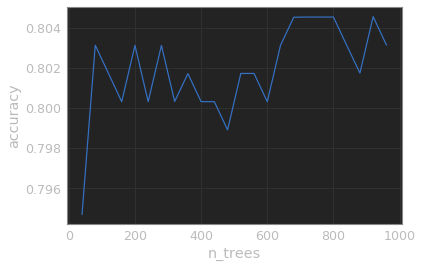

In [87]:
plt.plot(n_trees,cv_results_accuracy)
plt.xlabel("n_trees");plt.ylabel("accuracy")

Text(0, 0.5, 'AUC')

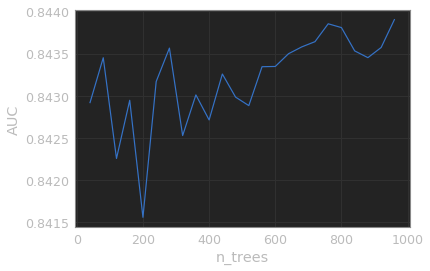

In [88]:
plt.plot(n_trees,cv_results_auc)
plt.xlabel("n_trees");plt.ylabel("AUC")

760 - best result

In [93]:
model = clf_model(xgboost.XGBClassifier(n_estimators=760,learning_rate=0.001,max_depth=4,subsample=0.5,n_jobs=-1,random_state=0)).fit(X_train,y_train)
accuracy_score(y_test,model.predict(X_test))

0.8707865168539326

In [101]:
l = [0.001,0.005,0.01,0.05,0.1,0.2,0.4,0.5]
xgb_clfs_l1 = [clf_model(xgboost.XGBClassifier(reg_alpha=n,n_estimators=760,learning_rate=0.001,max_depth=4,subsample=0.5,n_jobs=-1,random_state=0)) for n in l]
xgb_clfs_l2 = [clf_model(xgboost.XGBClassifier(reg_lambda=n,n_estimators=760,learning_rate=0.001,max_depth=4,subsample=0.5,n_jobs=-1,random_state=0)) for n in l]

In [102]:
cv_results_accuracy_l1 = []
cv_results_auc_l1 = []
cv_results_accuracy_l2 = []
cv_results_auc_l2 = []
for clf in xgb_clfs_l1:
    cv_results_accuracy_l1.append(cross_val_score(clf,X_train,y_train,cv=5,scoring="accuracy").mean())
    cv_results_auc_l1.append(cross_val_score(clf,X_train,y_train,cv=5,scoring="roc_auc").mean())  
for clf in xgb_clfs_l2:
    cv_results_accuracy_l2.append(cross_val_score(clf,X_train,y_train,cv=5,scoring="accuracy").mean())
    cv_results_auc_l2.append(cross_val_score(clf,X_train,y_train,cv=5,scoring="roc_auc").mean())  

[Text(0, 0.5, 'auc'), Text(0.5, 0, 'l')]

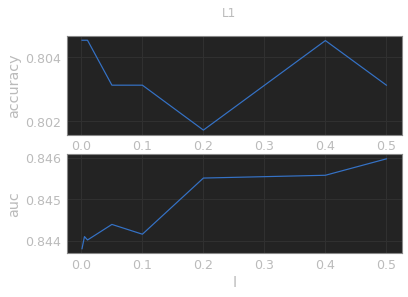

In [107]:
fig, axs = plt.subplots(2)
fig.suptitle('L1')
axs[0].plot(l,cv_results_accuracy_l1)
axs[1].plot(l,cv_results_auc_l1)
axs[0].set(xlabel='l', ylabel='accuracy')
axs[1].set(xlabel='l', ylabel='auc')

[Text(0, 0.5, 'auc'), Text(0.5, 0, 'l')]

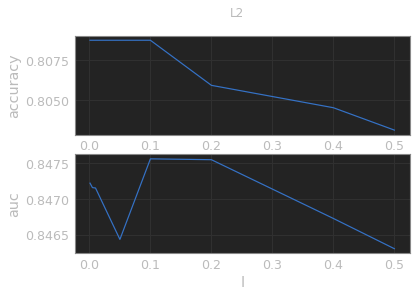

In [108]:
fig, axs = plt.subplots(2)
fig.suptitle('L2')
axs[0].plot(l,cv_results_accuracy_l2)
axs[1].plot(l,cv_results_auc_l2)
axs[0].set(xlabel='l', ylabel='accuracy')
axs[1].set(xlabel='l', ylabel='auc')

In [123]:
model = clf_model(xgboost.XGBClassifier(reg_lambda=0.1,n_estimators=760,learning_rate=0.001,max_depth=4,subsample=0.5,n_jobs=-1,random_state=0)).fit(X_train,y_train)
accuracy_score(y_test,model.predict(X_test))

0.8707865168539326

To sum up, our best model was SVC with polynomial kernel, which achived 79% accuracy on kagle test dataset.